In [1]:
# Instalação de bibliotecas necessárias
!pip install pandas matplotlib

# Importando as bibliotecas necessárias
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# Carregando os arquivos CSV
df_target_store = pd.read_csv('/content/drive/MyDrive/Tables/target_store_final_v6.csv')  # Arquivo com as metas de vendas por loja
df_store_info = pd.read_csv('/content/drive/MyDrive/Tables/store_final.csv')  # Arquivo com informações das lojas
df_transactions_2022 = pd.read_csv('/content/drive/MyDrive/Tables/transaction_fact_v6_2022.csv')
df_transactions_2023 = pd.read_csv('/content/drive/MyDrive/Tables/transaction_fact_v6_2023.csv')
df_transactions_2024 = pd.read_csv('/content/drive/MyDrive/Tables/transaction_fact_v6_2024.csv')

In [3]:
# Unindo todos os arquivos de transações em um único DataFrame
df_transactions = pd.concat([df_transactions_2022, df_transactions_2023, df_transactions_2024], ignore_index=True)

In [4]:
# Convertendo a coluna 'data' das transações para o formato datetime
df_transactions['data'] = pd.to_datetime(df_transactions['data'])

# Criando uma coluna 'mes_ano' no formato MM/AAAA para combinar com o formato do target
df_transactions['mes_ano'] = df_transactions['data'].dt.strftime('%m/%Y')

# Verificando as primeiras linhas para confirmação
df_transactions.head()

,data,cod_vendedor,cod_loja,cod_transacao,quantidade,cod_prod,preco,mes_ano
0,2022-12-24,6,MG_54,00118ede66,2,177899640966,33.126638,12/2022
1,2022-12-26,293,SC_18,001385984a,2,976845836046,279.660091,12/2022
2,2022-12-07,717,SP Interior_44,0015140802,2,144605328548,136.712123,12/2022
3,2022-12-23,328,SC_49,00190c34b6,1,279257544142,16.563319,12/2022
4,2022-12-27,907,SP Capital Centro_99,001db654f0,1,11815053167,110.826110,12/2022


In [5]:
def calcular_remuneracao_gerente(store_id, mes_ano):
    # Filtrando o target para o store_id e mês/ano fornecidos
    target_filtrado = df_target_store[(df_target_store['store_id'] == store_id) & (df_target_store['month'] == mes_ano)]

    # Verificando se existe um target para o store_id e mês/ano fornecidos
    if target_filtrado.empty:
        print(f"Nenhum target encontrado para a loja {store_id} no mês/ano {mes_ano}. Verifique os inputs.")
        return

    target_loja = target_filtrado['sales_target'].values[0]

    # Filtrando as transações da loja para o mês/ano fornecido
    transacoes_loja = df_transactions[(df_transactions['cod_loja'] == store_id) & (df_transactions['mes_ano'] == mes_ano)]

    # Calculando o total de vendas da loja no mês/ano
    total_vendas_loja = transacoes_loja['preco'].sum()

    # Comparando com o target
    atingiu_target = total_vendas_loja >= target_loja

    # Encontrando a região da loja
    regiao_filtrada = df_store_info[df_store_info['nome_loja'].str.contains(store_id)]

    if regiao_filtrada.empty:
        print(f"Nenhuma região encontrada para a loja {store_id}. Verifique os inputs.")
        return

    regiao_loja = regiao_filtrada['regiao'].values[0]

    # Filtrando as lojas da mesma região
    lojas_mesma_regiao = df_store_info[df_store_info['regiao'] == regiao_loja]['nome_loja'].tolist()

    # Filtrando as transações das lojas da mesma região para o mês/ano fornecido
    transacoes_regiao = df_transactions[(df_transactions['cod_loja'].isin(lojas_mesma_regiao)) & (df_transactions['mes_ano'] == mes_ano)]

    # Verificando se há transações na região
    if transacoes_regiao.empty:
        print(f"Nenhuma transação encontrada para as lojas na região {regiao_loja} no mês/ano {mes_ano}.")
        return

    # Calculando as vendas totais de cada loja da região
    vendas_por_loja = transacoes_regiao.groupby('cod_loja')['preco'].sum()

    # Verificando se a loja foi a que mais vendeu na região
    mais_vendeu_regiao = total_vendas_loja == vendas_por_loja.max()

    # Determinando a posição da loja no ranking de vendas
    ranking = vendas_por_loja.rank(ascending=False, method='min')
    posicao_loja = ranking[store_id]

    # Calculando a remuneração do gerente
    remuneracao_gerente = 5000  # Salário base
    if atingiu_target:
        remuneracao_gerente += 3000  # Bônus por atingir o target
    if mais_vendeu_regiao:
        remuneracao_gerente += 2000  # Bônus por ser a loja que mais vendeu na região

    # Exibindo a remuneração calculada
    print(f'Remuneração do gerente da loja {store_id} para {mes_ano}: R$ {remuneracao_gerente:.2f}')

    # Exibindo os valores absolutos do target e das vendas
    print(f"Target de vendas para {mes_ano}: R$ {target_loja:.2f}")
    print(f"Total de vendas realizadas pela loja {store_id} em {mes_ano}: R$ {total_vendas_loja:.2f}")
    if atingiu_target:
        print("O gerente atingiu o target de vendas.")
    else:
        print("O gerente não atingiu o target de vendas.")

    # Exibindo a posição da loja no ranking
    print(f"Posição da loja {store_id} no ranking de vendas da região {regiao_loja}: {int(posicao_loja)}ª posição")
    if mais_vendeu_regiao:
        print("A loja foi a que mais vendeu na região.")
    else:
        print("A loja não foi a que mais vendeu na região.")

    # Verificando se há dados para plotar o gráfico de desempenho
    plt.figure(figsize=(12, 5))

    # Gráfico de comparação de vendas com o target
    plt.subplot(1, 2, 1)
    plt.bar(['Target', 'Vendas Realizadas'], [target_loja, total_vendas_loja], color=['blue', 'green'])
    plt.title(f'Desempenho da Loja {store_id} em {mes_ano}')
    plt.ylabel('Vendas (R$)')

    # Verificando se há dados para plotar o gráfico de comparação entre as lojas da região
    plt.subplot(1, 2, 2)
    vendas_por_loja.plot(kind='bar', color='purple')
    plt.axhline(total_vendas_loja, color='red', linestyle='--', label=f'Vendas da Loja {store_id}')
    plt.title(f'Comparação de Vendas na Região {regiao_loja} em {mes_ano}')
    plt.ylabel('Vendas (R$)')
    plt.legend()

    plt.tight_layout()
    plt.show()


Remuneração do gerente da loja RJ_37 para 12/2022: R$ 5000.00
Target de vendas para 12/2022: R$ 110921.00
Total de vendas realizadas pela loja RJ_37 em 12/2022: R$ 101132.26
O gerente não atingiu o target de vendas.
Posição da loja RJ_37 no ranking de vendas da região RJ: 20ª posição
A loja não foi a que mais vendeu na região.


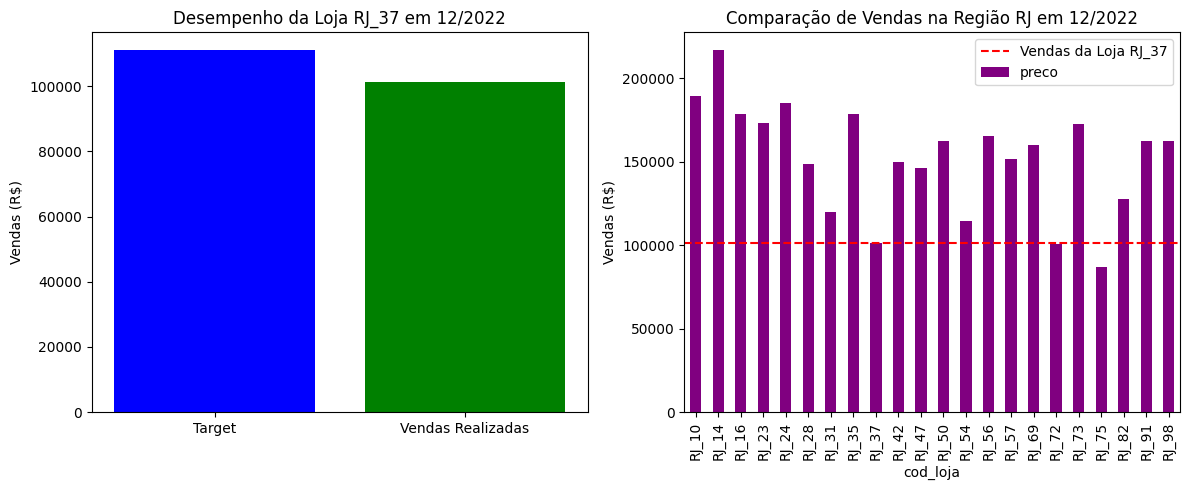

In [6]:
# Executando a função com uma loja e mês/ano específicos
calcular_remuneracao_gerente('RJ_37', '12/2022')